<a href="https://colab.research.google.com/github/baar2/bart/blob/main/EE302_mt2(study)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, N):
        super(Net, self).__init__()
        # nn.Conv2d(in_channels=, out_channels=, kernel_size=, stride=, padding=)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=N, kernel_size=3, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(N, N, kernel_size=2, stride=3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(N, N, kernel_size=2, stride=1)
        self.batchnorm = nn.BatchNorm2d(num_features=N) # batch normalization
        self.maxpool = nn.MaxPool2d(kernel_size=2) # max pooling
        self.dropout1 = nn.Dropout(p=0.5) # use this to implement torch.flatten in forward
        self.fc = nn.Linear(in_features=N, out_features=10) # fully-connected

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)

        # x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
# Define a function to train the model
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate (train_loader):
        # data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        # loss = criterion(output, target) use CrossEntropyLoss = sigmoid + nll._loss

        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break



In [4]:
# Define a function to evaluate the model
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16554985.80it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 497522.13it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4473456.00it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 4517554.84it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [10]:
# Select an image from the dataset
index = 0  # Choose the index of the image you want to plot
image, label = train_dataset[index]

model = Net(32)
output = model(image.unsqueeze(0))

filters = model.conv1

output_image = filters(image)

print(output_image.shape)
print(image.shape)
print(output)

torch.Size([32, 13, 13])
torch.Size([1, 28, 28])
tensor([[-1.5290, -2.8459, -3.5286, -2.7742, -3.1645, -3.2939, -1.2922, -2.4414,
         -2.0664, -2.7222]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
import matplotlib.pyplot as plt

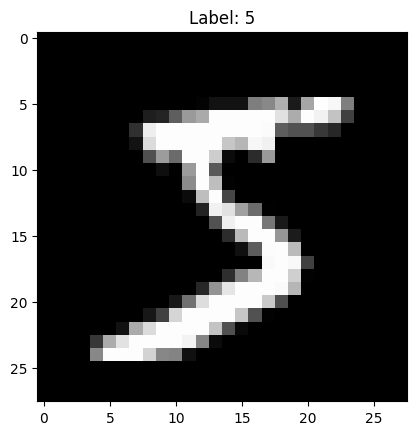

In [12]:
# Use Matplotlib to display the image
plt.imshow(image.squeeze().numpy(), cmap='gray')  # Squeeze to remove the channel dimension
plt.title(f"Label: {label}")
plt.show()

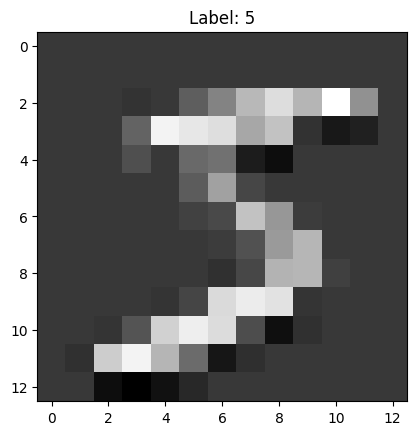

In [13]:
# Use Matplotlib to display the filtered image
plt.imshow(output_image[31,:,:].squeeze().detach().numpy(), cmap='gray')  # Squeeze to remove the channel dimension
plt.title(f"Label: {label}")
plt.show()

In [14]:
# Argument parsing

import argparse

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=2, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args(args=[])

use_cuda = False
torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [15]:
# Hyperparameters and values to tune
learning_rates = [0.1]
N_values = [3]
minibatch_sizes = [32]
epoch = 1

In [16]:
nominator = 0
denominator = 0

for imgs, labels in test_loader:
  predictions = model(imgs)
  for label, prediction in zip(labels, predictions):
    if label.item() == 1:
      if torch.argmax(prediction).item() == 2:
        nominator += 1
      denominator += 1

  print(nominator, denominator, nominator / denominator)

4 126 0.031746031746031744
6 234 0.02564102564102564
16 340 0.047058823529411764
16 450 0.035555555555555556
19 571 0.03327495621716287
25 686 0.03644314868804665
30 795 0.03773584905660377
36 905 0.039779005524861875
38 1016 0.03740157480314961
44 1135 0.038766519823788544


In [17]:
# Iterate over the hyperparameters, train the model, and evaluate its accuracy

from torch.optim.lr_scheduler import StepLR, ExponentialLR

for lr in learning_rates:
    for N in N_values:
        for minibatch_size in minibatch_sizes:
            model = Net(N).to(device)  # Use N for the Net model initialization
            #print(sum(p.numel() for p in model.parameters()))
            optimizer = optim.Adadelta(model.parameters(), lr=lr)
            scheduler = ExponentialLR(optimizer, gamma=args.gamma)
            for epoch in range(1, epochs + 1):  # Use epochs instead of args.epochs
                train(args, model, device, train_loader, optimizer, epoch)
                accuracy = evaluate(model, device, test_loader)
                scheduler.step()






NameError: name 'epochs' is not defined